## This notebook illustrates some subroutines for comparing cantera to Bilbo.

It reads in a list of experimental conditions, runs the simulation for those conditions, and writes files to compare with Bilbo simulations.

The examples are based upon John Randazzo's isopentyl-nitrite work.

In [1]:
import cantera as ct
import numpy as np
import scipy
import scipy.integrate
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
import time

%matplotlib inline

# declare a class for each Schlieren Experiment
class Simulation:
    run_name=""
    
# adapted from the CatTech Shock and Detonation Toolbox of Joe Shepherd.
def calc_postshock(gas, U1, rtol=1e-10):
    """
    Calculates frozen post-shock state for a specified shock velocity. The state
    of the gas object will reflect the post-shock state. Returns the post-shock
    velocity.

    :param gas:
        Solution object in the initial, pre-shock state
    :param U1:
        shock speed [m/s]
    """

    r1 = gas.density
    V1 = 1/r1
    P1 = gas.P
    T1 = gas.T
    H1 = gas.enthalpy_mass

    i = 0
    # Initial guess
    V = V1/5
    P = P1 + r1*(U1**2)*(1-V/V1)
    T = T1*P*V/(P1*V1)
    gas.TD = T, 1/V
    FH = FP = 1e8

    while(abs(FH/(gas.cp * T)) > rtol or abs(FP/gas.P) > rtol):
        i += 1
        if i == 500:
            raise Exception("shk_calc did not converge for U = %s" % U1)

        # Calculate FH, FP, and their derivatives
        r2 = gas.density
        w2s = U1**2 * (r1/r2)**2
        FH = gas.enthalpy_mass + 0.5*w2s - (H1 + 0.5*U1**2)
        FP = gas.P + r2*w2s - (P1 + r1*U1**2)

        DFHDT = gas.cp_mass
        DFPDT = gas.P / gas.T
        DFHDV = U1**2 * r1**2 / gas.density
        DFPDV = - gas.P * gas.density + U1**2 * r1**2

        # Construct Jacobian and solve
        J = DFHDT*DFPDV - DFPDT*DFHDV
        b = [DFPDV, -DFHDV, -DFPDT, DFHDT]
        a = [-FH, -FP]
        deltaT = (b[0]*a[0]+b[1]*a[1])/J
        deltaV = (b[2]*a[0]+b[3]*a[1])/J

        # limit changes in temperature and volume
        DTM = 0.2*T
        if abs(deltaT) > DTM:
            deltaT = DTM*deltaT/abs(deltaT)

        if V + deltaV > V1:
            DVM = 0.5*(V1 - V)
        else:
            DVM = 0.2*V
        if abs(deltaV) > DVM:
            deltaV = DVM*deltaV/abs(deltaV)

        # Apply increments to T and V
        T += deltaT
        V += deltaV
        gas.TD = T, 1/V

    return U1*r1 / gas.density


# Here is the main ODE solver
class ReactorOde(object):
    def __init__(self, gas, rhoI, L, As, A1, area_change):
        # Parameters of the ODE system and auxiliary data are stored in the
        # ReactorOde object.
        self.gas = gas
        self.N = gas.n_species + 6
        self.L = L
        self.As = As
        self.A1 = A1
        self.n = 0.5
        self.Wk = self.gas.molecular_weights
        self.rho1 = gas.density
        self.rhoI = rhoI        #initial density
        self.delta_dA = 1 if area_change else 0

    def __call__(self, t, y):
        """the ODE function, y' = f(t,y) """

        # State vector is [z, A, rho, v, T, tlab, Y_1, Y_2, ... Y_K]
        #                  0  1   2   3  4   5    6 ...
        z, A, rho, v, T, tlab = y[:6]
        self.gas.set_unnormalized_mass_fractions(y[6:])
        self.gas.TD = T, rho
        cp = self.gas.cp_mass
        Wmix = self.gas.mean_molecular_weight
        hk = self.gas.partial_molar_enthalpies
        wdot = self.gas.net_production_rates

        beta = v**2 * (1.0/(cp*T) - Wmix / (ct.gas_constant * T))
        xi = max(z / self.L, 1e-10)

        ydot = np.zeros(self.N)
        ydot[0] = v # dz/dt
        ydot[1] = self.delta_dA * v * self.As*self.n/self.L * xi**(self.n-1.0)/(1.0-xi**self.n)**2.0 # dA/dt
        ydot[6:] = wdot * self.Wk / rho # dYk/dt
        ydot[2] = 1/(1+beta) * (sum((hk/(cp*T) - Wmix) * wdot) - rho*beta/A * ydot[1]) # drho/dt
        ydot[3] = - v * (ydot[2]/rho + ydot[1]/A) # dv/dt
        ydot[4] = - (np.dot(wdot, hk)/rho + v*ydot[3]) / cp # dT/dt
        ydot[5] = self.rhoI*self.A1 / (rho*A) # dt_lab/dt

        return ydot

    #--------------------------------------------------------------------------------
    # POST PROCESSING
    #--------------------------------------------------------------------------------

    # compute the density gradient from the solution
    def drhodz(self, t, y):
        z, A, rho, v, T, tlab = y[:6]
        self.gas.set_unnormalized_mass_fractions(y[6:])
        self.gas.TD = T, rho
        cp = self.gas.cp_mass
        Wmix = self.gas.mean_molecular_weight
        hk = self.gas.partial_molar_enthalpies
        wdot = self.gas.net_production_rates

        beta = v**2 * (1.0/(cp*T) - Wmix / (ct.gas_constant * T))
        xi = max(z / self.L, 1e-10)

        dAdt = self.delta_dA * v * self.As*self.n/self.L * xi**(self.n-1.0)/(1.0-xi**self.n)**2.0 # dA/dt

        return 1/v/(1+beta) * (sum((hk/(cp*T) - Wmix) * wdot) - rho*beta/A * dAdt)

    # compute the contribution of each reaction to the density gradient
    def drhodz_per_rxn(self, t, y):
        z, A, rho, v, T, tlab = y[:6]
        self.gas.set_unnormalized_mass_fractions(y[6:])
        self.gas.TD = T, rho
        cp = self.gas.cp_mass
        Wmix = self.gas.mean_molecular_weight
        hk = self.gas.partial_molar_enthalpies
        wdot = self.gas.net_production_rates

        beta = v**2 * (1.0/(cp*T) - Wmix / (ct.gas_constant * T))
        xi = max(z / self.L, 1e-10)

        dAdt = self.delta_dA * v * self.As*self.n/self.L * xi**(self.n-1.0)/(1.0-xi**self.n)**2.0 # dA/dt

        per_rxn = np.zeros(gas.n_reactions)
        rj = gas.net_rates_of_progress
        hj = gas.delta_enthalpy
        nu_fwd = gas.product_stoich_coeffs()
        nu_rev = gas.reactant_stoich_coeffs()

        for j in range(gas.n_reactions):
            delta_Nj = sum(nu_fwd[:,j]) - sum(nu_rev[:,j])
            per_rxn[j] = 1/v/(1+beta) * ( rj[j] * ( hj[j] / (cp*T)  - Wmix * delta_Nj)  - rho*beta/A * dAdt) 

        return per_rxn


# plot the temperature and reactant on one plot, and then the absolute value of the density gradient on another     
def plot_results(Simulation):

    fig = pylab.figure(dpi=120)
    fig.set_size_inches(8,5) #set size, in inches
    gs = gridspec.GridSpec(2, 1,height_ratios=[1,2])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])


    ax0.plot(Simulation.t_lab*1E6, Simulation.T_out, color='r', label='T', lw=2)
    ax0.plot(Simulation.t_lab*1E6, Simulation.T_out, color='r', label='T', lw=2)
    ax0.set_ylabel('Temperature (K)')
    ax0.set_xlabel('time ($\mu$s)')
    ax0.set_ylim(min(Simulation.T_out)*0.99, max(Simulation.T_out)*1.01)
    ax0.set_xlim(min(Simulation.t_lab*1E6)*0.999, max(Simulation.t_lab*1E6)*1.001)
    ax0.yaxis.label.set_color('r')

    ax0_2 = ax0.twinx()
    ax0_2.plot(Simulation.t_lab*1E6, Simulation.X_out[Simulation.gas.species_index(Simulation.reactant)], color='b', label='nitrite', lw=2)
    ax0_2.set_ylabel('nitrite mole fraction')
    ax0_2.yaxis.label.set_color('b')
    
    ax1.semilogy(Simulation.t_lab*1E6, np.abs(Simulation.drhodz), color='k', lw=2)
    ax1.set_xlabel('time ($\mu$s)')
    ax1.set_ylabel('density gradient')
    ax1.set_xlim(min(Simulation.t_lab*1E6)*0.999, max(Simulation.t_lab*1E6)*1.001)
    ax1.set_ylim(min(np.abs(Simulation.drhodz))*0.9, max(np.abs(Simulation.drhodz))*1.1)
    T2 = Simulation.T_out[0]
    P2 = Simulation.P_out[0]/ct.one_atm*760.0
    cond = 'exp. $T_2$ = %.0F K\n$P_2$ = %.0F Torr'%(T2,P2)
    ax1.annotate(cond, xy=(0.8, 0.9), xycoords='axes fraction',verticalalignment='top')   
    fig.tight_layout()

    return 


# plot the density gradient per reaction
def plot_per_rxn(Simulation, legend=True):

    fig = pylab.figure(dpi=120)
    fig.set_size_inches(8,5) #set size, in inches
    gs = gridspec.GridSpec(1, 1)
    ax0 = plt.subplot(gs[0])
    
    # create a unique color for each reaction
    n_rxn = Simulation.gas.n_reactions
    mycolors=cm.rainbow(np.linspace(0,1,n_rxn))

    # specify the lower-limit of the y-axis. This is used to select which reactions to include
    y_min = min(np.abs(Simulation.drhodz))*0.9 
    for rxn in range(n_rxn):
        rxn_label = Simulation.gas.reaction_equation(rxn)
        if max(Simulation.drhodz_per_rxn[rxn,:])>y_min:
            ax0.semilogy(Simulation.t_lab*1E6, (Simulation.drhodz_per_rxn[rxn,:]), color=mycolors[rxn], lw=2, label=rxn_label)
        if max(-Simulation.drhodz_per_rxn[rxn,:])>y_min:
            ax0.semilogy(Simulation.t_lab*1E6, -(Simulation.drhodz_per_rxn[rxn,:]), ':', color=mycolors[rxn], lw=2, label=rxn_label)
            
    ax0.semilogy(Simulation.t_lab*1E6, np.abs(Simulation.drhodz), color='k', lw=4)        
    ax0.set_xlabel('time ($\mu$s)')
    ax0.set_ylabel('density gradient')
    ax0.set_xlim(min(Simulation.t_lab*1E6)*0.999, max(Simulation.t_lab*1E6)*1.001)
    ax0.set_ylim(y_min, max(np.abs(Simulation.drhodz))*1.1)
    if legend==True:
        ax0.legend(loc='best')
    fig.tight_layout()

    return 
    
def mimic_Bilbo_output(Simulation):
    
    # first create output for density gradient per reaction
    dRhodx = open('dRhodx.txt', 'w')
    header = "Density gradient per reaction\n\n"
    dRhodx.write(header)
    #write the times
    timeline = "Time(us)"
    for t in range(len(Simulation.t_lab)):
        timeline += "\t%.1F"%(Simulation.t_lab[t]*1e6)
    timeline += '\n'
    dRhodx.write(timeline)
    for rxn in range(Simulation.gas.n_reactions):
        print Simulation.gas.reaction_equations()[rxn]
        drholine = ''
        for t in range(len(Simulation.t_lab)):
            drholine += "\t%.4E"%(Simulation.drhodz_per_rxn[rxn,t]*1.0E-5)
        drholine += '\n'
        dRhodx.write(drholine)
    dRhodx.close()
    
    # now create output for density gradient per reaction
    Percent = open('Percent.txt', 'w')
    header = "Percent contribution to total dr/dx per reaction\n\n"
    Percent.write(header)
    #write the times
    timeline = "Time(us)"
    for t in range(len(Simulation.t_lab)):
        timeline += "\t%.1F"%(Simulation.t_lab[t]*1e6)
    timeline += '\n'
    Percent.write(timeline)
    for rxn in range(Simulation.gas.n_reactions):
        percentline = ''
        for t in range(len(Simulation.t_lab)):
            percentline += "\t%.1F"%( (Simulation.drhodz[t] - Simulation.drhodz_per_rxn[rxn,t])/Simulation.drhodz[t] * 100.0 )
        percentline += '\n'
        Percent.write(percentline)
    Percent.close()    
    
     
    # now create output for density gradient per reaction
    Concs = open('Concs.txt', 'w')
    
    header = "Time\tTemp\tPres"

    for spec in range(Simulation.gas.n_species):
        header += "\t%s"%( Simulation.gas.species_names[spec] )
    header += '\n'
    Concs.write(header)
    
    for t in range(len(Simulation.t_lab)):
        timeline = ""
        timeline += "\t%.2F"%(Simulation.t_lab[t]*1e6)
        
        timeline += "\t%.1F"%(Simulation.T_out[t])
        timeline += "\t%.1F"%(Simulation.P_out[t]/ct.one_atm*760.0)        
        
        for spec in range(Simulation.gas.n_species):
            timeline += "\t%.4E"%( Simulation.Conc_out[spec,t]*1.0E-3 )
        timeline += '\n'
        Concs.write(timeline)
    Concs.close()    
    
    return
    

    #--------------------------------------------------------------------------------
    # Master Routine.
    #--------------------------------------------------------------------------------    
def get_density_gradient(Simulation):
    
    gas = Simulation.gas
    rhoI = gas.density
    # compute the frozen state behind the incident shock
    U1 = calc_postshock(gas, Simulation.UI)

    A1 = 0.2 #0.2
    As = 0.2 #0.2
    L = 0.1

    # Initial condition
    y0 = np.hstack((0.0, A1, gas.density, U1, gas.T, 0.0, gas.Y))

    # Set up objects representing the ODE and the solver
    ode = ReactorOde(gas, rhoI, L, As, A1, False)
    solver = scipy.integrate.ode(ode)
    solver.set_integrator('vode', method='bdf', with_jacobian=True, nsteps=1000)
    #solver.set_integrator('lsoda', with_jacobian=True, nsteps=10000)
    solver.set_initial_value(y0, 1e-20)

    # Integrate the equations, keeping T(t) and Y(k,t)
    t_end =50e-6
    t_out = [0.0]
    T_out = [gas.T]
    P_out = [gas.P]
    Y_out = [gas.Y]
    X_out = [gas.X]
    Conc_out = [gas.concentrations]
    v_out = [U1]
    A_out = [A1]
    drhodz = [ode.drhodz(0.0, y0)]
    drhodz_per_rxn =  [ode.drhodz_per_rxn(0.0, y0)]
    rho_out = [gas.density]
    z_out = [0.0]
    t_lab = [0.0]


    dt = t_end/100

    while solver.successful() and solver.t < t_end:
        try:
            solver.integrate(solver.t + dt)
        except Exception as e:
            print e
            break
        t_out.append(solver.t)
        z_out.append(solver.y[0])
        T_out.append(solver.y[4])
        Y_out.append(solver.y[6:])
        A_out.append(solver.y[1])
        v_out.append(solver.y[3])
        rho_out.append(solver.y[2])
        t_lab.append(solver.y[5])
        gas.Y = solver.y[6:]
        X_out.append(gas.X)
        P_out.append(gas.P)
        Conc_out.append(gas.concentrations)
        drhodz.append(ode.drhodz(solver.t, solver.y))
        drhodz_per_rxn.append( ode.drhodz_per_rxn(solver.t, solver.y))
        #print "%.d\t%.2F"%(len(t_out), solver.t*1E6)

    Simulation.t_gas = np.array(t_out)        
    Simulation.z_out = np.array(z_out)
    Simulation.T_out = np.array(T_out)
    Simulation.P_out = np.array(P_out)    
    Simulation.A_out = np.array(A_out)
    Simulation.v_out = np.array(v_out)    
    Simulation.rho_out = np.array(rho_out)    
    Simulation.drhodz = np.array(drhodz)    
    Simulation.Y_out = np.array(Y_out).T
    Simulation.X_out = np.array(X_out).T
    Simulation.Conc_out = np.array(Conc_out).T
    
    Simulation.drhodz_per_rxn = np.array(drhodz_per_rxn).T
    #print len(t_out)
    Simulation.t_lab = np.array(t_lab)
 
    return



In [2]:
# select mechanism
gas = ct.Solution('tranter.cti')

#read in the experimental data
experimental_conditions = open("experimental_conditions.txt", 'r')
lines = experimental_conditions.readlines()
experimental_conditions.close()

conditions = []
for i in range(len(lines)-1):
    bits = lines[i+1].split()
    conditions.append(bits)

conditions = np.array(conditions)    

In [3]:
# define the state

List_of_runs = []

for i in range(len(conditions)):
#for i in range(1):
    run = Simulation()
    P1_exp = float(conditions[i][0]) #Torr
    T1_exp = float(conditions[i][1]) #degC
    P2_exp = float(conditions[i][2]) #Torr
    T2_exp = float(conditions[i][3]) #K
    UI_exp = float(conditions[i][4]) #mm/us

    #unit conversions
    P1 = P1_exp / 760.0 * ct.one_atm  # Pa
    T1 = T1_exp + 273.15 #Kelvin
    UI = UI_exp * 1000.0 #Incident Shock Speed (m/s)

    X1 = 'KR:0.98, iC5H11ONO:0.02' #initial composition of the driven gas, in mole fractions
    gas.TPX = T1, P1, X1
    run.gas = gas
    run.UI = UI
    run.reactant = 'iC5H11ONO'

    if (1==0):
        # compute the frozen state behind the incident shock
        U1 = calc_postshock(gas, UI)
        T2_calc = gas.T
        P2_calc = gas.P / ct.one_atm * 760.0 #Torr
        print "%.1F\t%.1F\t\t%.1F\t%.1F\t\t%.3F\t%.3F"%(T2_exp, P2_exp, T2_calc, P2_calc, \
                                                        T2_exp/T2_calc, P2_exp/P2_calc)
    if (1==1):
        get_density_gradient(run)
        #plot_results(run)
    List_of_runs.append(run)
        

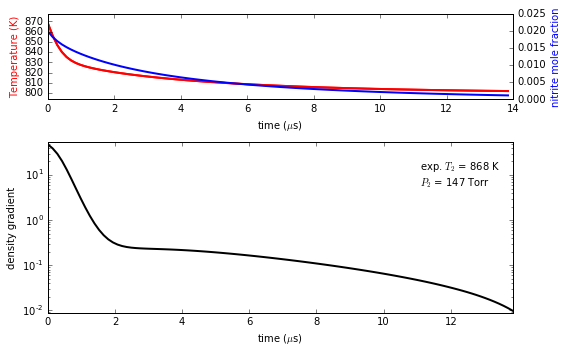

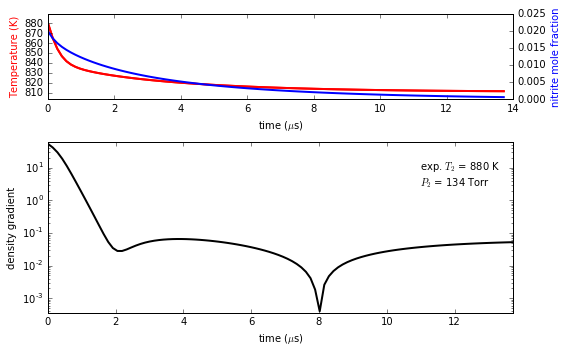

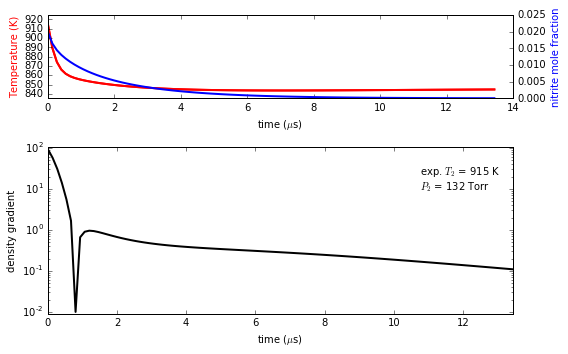

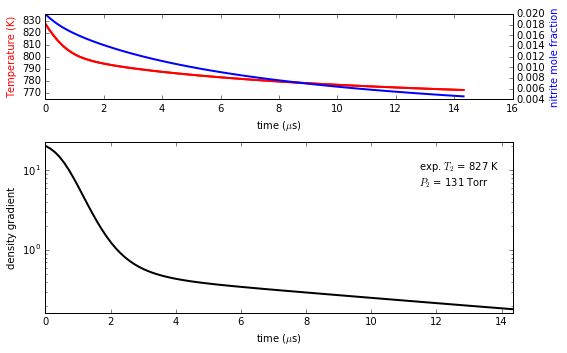

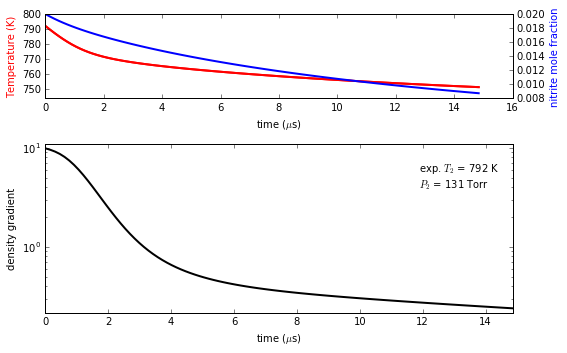

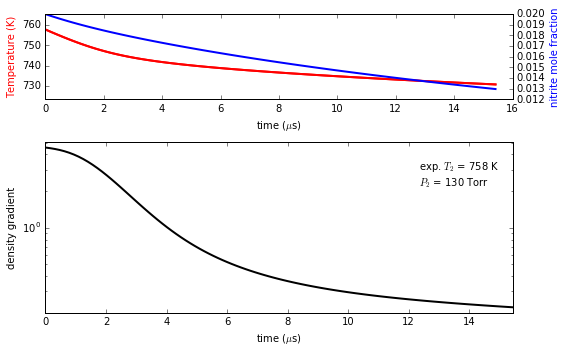

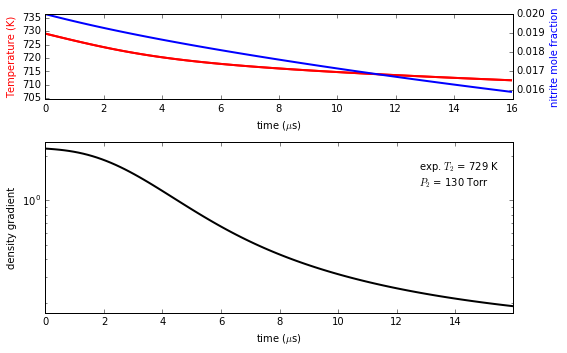

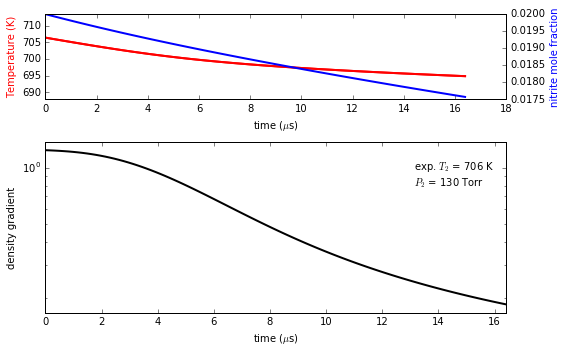

In [4]:
for run in List_of_runs:
    plot_results(run)

In [5]:


for i in range(len(List_of_runs)):
    run = List_of_runs[i]
    mimic_Bilbo_output(run)
    
 
    

iC5H11ONO <=> H2CO + NO + iC4H9
iC4H9 <=> C3H6 + CH3
iC4H9 <=> H + iC4H8
2 iC4H9 <=> DMH25
2 iC4H9 <=> iC4H10 + iC4H8
H + iC4H9 <=> H2 + iC4H8
H + iC4H9 <=> iC4H10
CH3 + iC4H9 <=> iC5H12
CH3 + iC4H9 <=> CH4 + iC4H8
2 CH3 <=> C2H6
iC5H11ONO <=> H2CO + NO + iC4H9
iC4H9 <=> C3H6 + CH3
iC4H9 <=> H + iC4H8
2 iC4H9 <=> DMH25
2 iC4H9 <=> iC4H10 + iC4H8
H + iC4H9 <=> H2 + iC4H8
H + iC4H9 <=> iC4H10
CH3 + iC4H9 <=> iC5H12
CH3 + iC4H9 <=> CH4 + iC4H8
2 CH3 <=> C2H6
iC5H11ONO <=> H2CO + NO + iC4H9
iC4H9 <=> C3H6 + CH3
iC4H9 <=> H + iC4H8
2 iC4H9 <=> DMH25
2 iC4H9 <=> iC4H10 + iC4H8
H + iC4H9 <=> H2 + iC4H8
H + iC4H9 <=> iC4H10
CH3 + iC4H9 <=> iC5H12
CH3 + iC4H9 <=> CH4 + iC4H8
2 CH3 <=> C2H6
iC5H11ONO <=> H2CO + NO + iC4H9
iC4H9 <=> C3H6 + CH3
iC4H9 <=> H + iC4H8
2 iC4H9 <=> DMH25
2 iC4H9 <=> iC4H10 + iC4H8
H + iC4H9 <=> H2 + iC4H8
H + iC4H9 <=> iC4H10
CH3 + iC4H9 <=> iC5H12
CH3 + iC4H9 <=> CH4 + iC4H8
2 CH3 <=> C2H6
iC5H11ONO <=> H2CO + NO + iC4H9
iC4H9 <=> C3H6 + CH3
iC4H9 <=> H + iC4H8
2 iC4H9

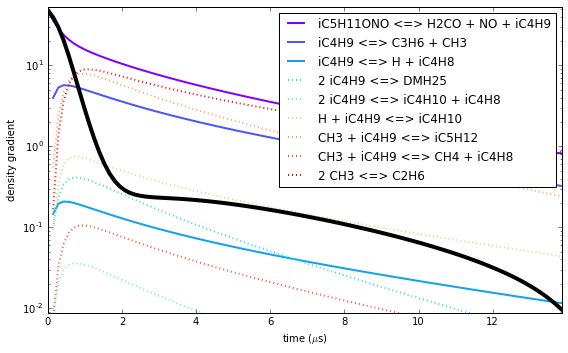

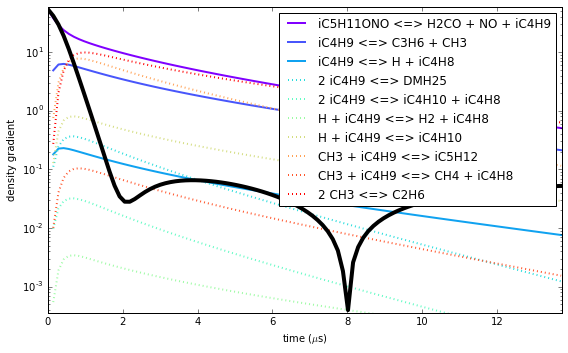

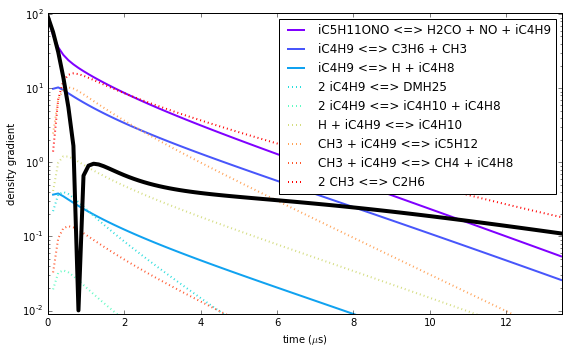

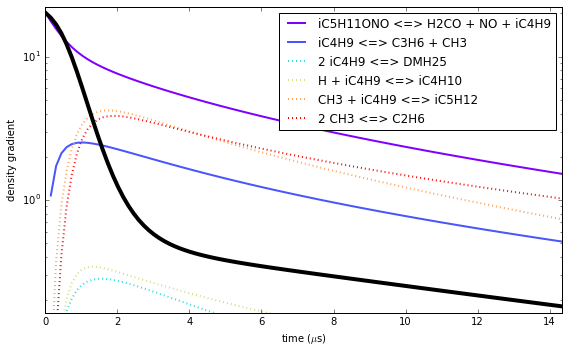

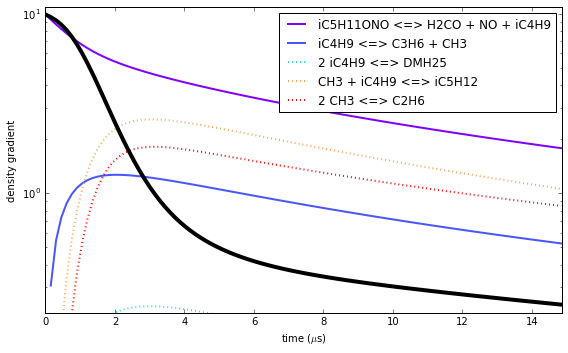

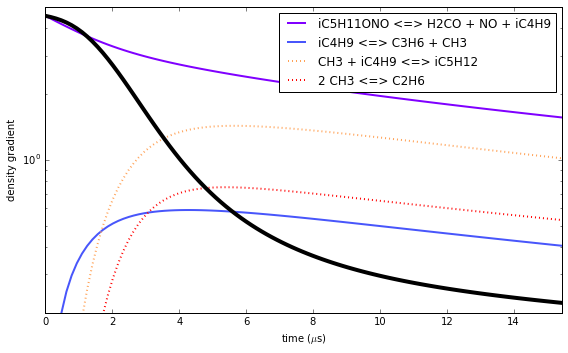

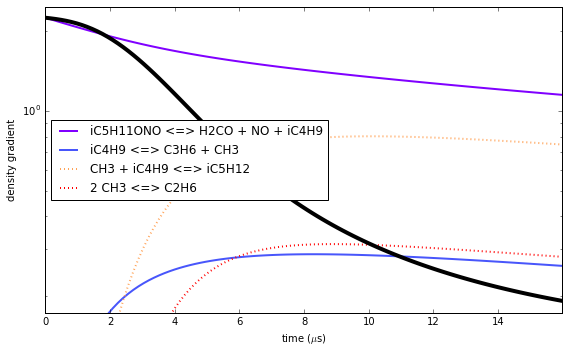

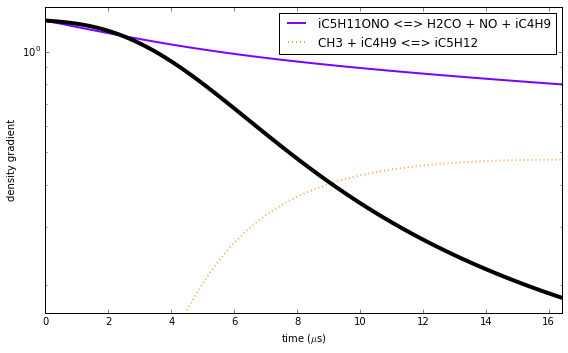

In [6]:
for run in List_of_runs:
#run1 = List_of_runs[0]
    plot_per_rxn(run, legend=True)